In [4]:
from hanzi2pinyin import hanzi2pinyin
h2p=hanzi2pinyin
import xlrd,random,copy
import numpy as np
import scipy as sp
import networkx as nx
import json
from sklearn.linear_model import Lasso
def change(s):
    ori=['sanqicun','jienaocun','yousancun','shangercun','honglinnongchang','quijiazhuangcun',\
    'qiaojiacun','honglinlinchang','lianhuacun','qiaosicun','xinhe']
    new=['shangsanqicun','jienaoqicun','yousanbacun','shangerqicun','honglincun','qiujiazhuang',\
    'qiaojiasicun','honglincun','lianhuashancun','qiaojiasicun','xinhecun']
    if s in ori:
        return new[ori.index(s)]
    return s
f=file('name2.txt','r')
pos={}
belong={}
for i in f:
    name,p1,p2=i[:-1].split()
    pos[change(name)]=(float(p1),float(p2))
f.close()
dis=lambda x,y:((x[0]-y[0])**2+(x[1]-y[1])**2)**0.5

wbk=xlrd.open_workbook('fulllist.xlsx')
sht=wbk.sheet_by_index(0)
for i in range(sht.nrows):
    belong[change(h2p(sht.cell(i,2).value))]=h2p(sht.cell(i,1).value[-3:])
for i in pos:
    if not i in belong:
        print i
towns=set(belong.values())
print len(towns)
stp=[15197954.7583,15575100.0]
class trade:
    def __init__(self, a=-1, b=-1, vol=-1, price=-1, date=-1):
        self.a,self.b,self.vol,self.price,self.date=a,b,vol,price,date
        self.feature={}
        if type(a)==str:
            self.getfeature()
    def tostr(self):
        return 'self.a,self.b,self.vol,self.price,self.date,self.feature=\'%s\',\'%s\',%lf,%lf,\'%s\',%s\n'%\
        (self.a,self.b,self.vol,self.price,self.date,self.feature)
    def fromstr(self,s):
        #coding=gbk
        exec s
        self.getfeature()
        return self
    def __getitem__(self,x):
        if x=='vol':
            return self.vol
        if x=='price':
            return self.price
        if x=='date':
            return self.date
        if x=='year':
            return int(self.date[-4:])
        if x=='a':
            return self.a
        if x=='b':
            return self.b
        return self.feature[x]
    def getfeature(self):
        self.feature['dis']=dis(pos[self.a],pos[self.b])/531021.5144183182


cons=[]
lost={}
trades=[]

10


In [6]:
f=file('features.txt','r')
trades=[trade().fromstr(h2p(i)) for i in f.readlines()]
# add a 'best fit' line
bads = []
for i in range(len(trades)):
    for j in range(i+1,len(trades)):
        flag=True
        for para in ['a','b','vol','price','year']:
            if trades[i][para]!=trades[j][para]:
                flag = False
        if flag:
            if i not in [92,362]:
                bads.append(i)
trades = [trades[i] for i in range(len(trades)) if i not in bads]


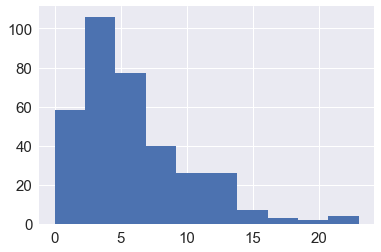

In [7]:
get_dis = lambda x,y: dis(pos[x],pos[y])/531021.5144183182

class Village:
    def __init__(self, name):
        self.name = name
        self.hist_p = []
        self.hist_q = []
        self.hist_sb = []  # sell or buy
        self.pos = pos[name]
        self.dropout = 0.5

    def prepare(self):
        if self.hist_p == []:
            return
        self.mean_p = np.mean(self.hist_p)
        self.mean_q = np.mean(self.hist_q)
        self.var_p = np.var(self.hist_p)
        self.var_q = np.var(self.hist_q)
        self.prob_s = self.hist_sb.count('s') * 1. / len(self.hist_sb)

    def get_instance(self):
        if random.random() < self.dropout or len(self.hist_p) == 0:
            return [-1,-1,-1]
        ret = []
        self.var_p = max(self.var_p, 1e-3)
        if random.random() < self.prob_s:
            ret.append('s')
            minp, maxp = self.mean_p - self.var_p**0.5, self.mean_p + 0.5 *self.var_p**0.5
        else:
            ret.append('b')
            minp, maxp = self.mean_p - 0.5* self.var_p**0.5, self.mean_p + self.var_p**0.5
        minp = max(minp, 0.1)
        tmp = np.random.normal(self.mean_p, self.var_p ** 0.5)
        while tmp > maxp or tmp < minp:
            tmp = np.random.normal(self.mean_p, self.var_p ** 0.5)
        ret.append(tmp)
        self.var_q = max(self.var_q, 1e-3)
        ret.append(max(1e4, np.random.normal(self.mean_q, self.var_q ** 0.5)))
        return ret

villages = {name: Village(name) for name in pos}

for trade in trades:
    villages[trade['a']].hist_p.append(trade['price'])
    villages[trade['b']].hist_p.append(trade['price'])
    villages[trade['a']].hist_q.append(trade['vol'])
    villages[trade['b']].hist_q.append(trade['vol'])
    villages[trade['a']].hist_sb.append('s')
    villages[trade['b']].hist_sb.append('b')

distances = [get_dis(trade['a'], trade['b']) for trade in trades]
plt.hist(distances)
plt.show()

In [8]:
for name in villages:
    villages[name].prepare()

In [9]:
data_cnt = 0
def generate_instance():
    global data_cnt
    sample = []
    for i in villages:
        sample.append(villages[i].get_instance())
    f = file('price_data/data%d.txt'%data_cnt, 'w')
    data_cnt += 1
    f.write(str(sample))

In [11]:
import os
os.mkdir('price_data')

In [12]:
for i in range(100):
    generate_instance()